What Factors Affect STEM Degree Completion Rates at Public Universities in the United States?

In [15]:
import pandas as pd 
import numpy as np 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [16]:
# Load the datasets
completions = pd.read_csv('IPEDS_Completions.csv')
Directory = pd.read_csv('IPEDS_Directory.csv')
Chareges = pd.read_csv('IPEDS_Charges.csv')

In [17]:
# shape of the loaded Datasets withe lable  as a table
print('completions shape:', completions.shape)
print('Directory shape:', Directory.shape)
print('Chareges shape:', Chareges.shape)

completions shape: (300877, 64)
Directory shape: (6256, 73)
Chareges shape: (3876, 235)


In [18]:
completions.head()

,UNITID,CIPCODE,MAJORNUM,AWLEVEL,XCTOTALT,CTOTALT,XCTOTALM,CTOTALM,XCTOTALW,CTOTALW,...,XCUNKNM,CUNKNM,XCUNKNW,CUNKNW,XCNRALT,CNRALT,XCNRALM,CNRALM,XCNRALW,CNRALW
0,100654,1.0999,1,5,R,9,R,3,R,6,...,Z,0,Z,0,Z,0,Z,0,Z,0
1,100654,1.1001,1,5,R,7,R,3,R,4,...,Z,0,Z,0,Z,0,Z,0,Z,0
2,100654,1.1001,1,7,R,7,R,1,R,6,...,Z,0,R,2,R,2,R,1,R,1
3,100654,1.1001,1,17,R,3,R,1,R,2,...,Z,0,Z,0,Z,0,Z,0,Z,0
4,100654,1.9999,1,5,R,1,R,1,Z,0,...,Z,0,Z,0,Z,0,Z,0,Z,0


In [19]:
Directory.head(2)

,UNITID,INSTNM,IALIAS,ADDR,CITY,STABBR,ZIP,FIPS,OBEREG,CHFNM,...,CBSA,CBSATYPE,CSA,COUNTYCD,COUNTYNM,CNGDSTCD,LONGITUD,LATITUDE,DFRCGID,DFRCUSCG
0,100654,Alabama A & M University,AAMU,4900 Meridian Street,Normal,AL,35762,1,5,Dr. Daniel K. Wims,...,26620,1,290,1089,Madison County,105,-86.568502,34.783368,107,1
1,100663,University of Alabama at Birmingham,UAB,Administration Bldg Suite 1070,Birmingham,AL,35294-0110,1,5,Ray L. Watts,...,13820,1,142,1073,Jefferson County,107,-86.799345,33.505697,92,1


In [20]:
Chareges.head()

,UNITID,XTUIT1,TUITION1,XFEE1,FEE1,XHRCHG1,HRCHG1,XTUIT2,TUITION2,XFEE2,...,XCHG8AY3,CHG8AY3,XCHG9AY0,CHG9AY0,XCHG9AY1,CHG9AY1,XCHG9AY2,CHG9AY2,XCHG9AY3,CHG9AY3
0,100654,R,8610,R,1414,R,287,R,8610,R,...,R,3090,R,3090,R,3440,R,3440,R,3440
1,100663,R,8832,R,0,R,368,R,8832,R,...,R,6007,R,5555,R,5555,R,5555,R,6007
2,100690,R,9000,R,950,R,430,R,9000,R,...,A,.,A,.,A,.,A,.,A,.
3,100706,R,10120,R,1758,R,421,R,10120,R,...,R,4462,R,3994,R,4076,R,4156,R,4462
4,100724,R,8328,R,2740,R,347,R,8328,R,...,R,5130,R,4228,R,4228,R,5130,R,5130


## Clean Data and simplify columns 

In [21]:
#clean missing 
#completions
completions = completions.dropna()
completions = completions.drop_duplicates()
#Directory
Directory = Directory.dropna()
Directory = Directory.drop_duplicates()
#Chareges
Chareges = Chareges.dropna()
Chareges = Chareges.drop_duplicates()




In [22]:
# Filter for public universities
public_universities =  Directory[Directory['CONTROL'] == 1]
public_university_ids = public_universities['UNITID'].unique()

In [23]:

# Define the CIP codes for STEM fields
# Replace with actual CIP codes for STEM fields
stem_cip_codes = [11, 14, 15, 26, 27, 40, 41, 52, 54, 62, 91, 15, 26, 52, 54, 62, 91]

In [24]:
# Filter completions for public universities and STEM fields CIP codes
completions['CIPCODE'] = completions['CIPCODE'].astype(str).str.split('.').str[0].astype(int)

In [25]:
# Filter for public universities and STEM programs
completions_stem = completions[(completions['UNITID'].isin(public_university_ids)) & 
                               (completions['CIPCODE'].isin(stem_cip_codes))]                               
#remove all the columns that start with XC
completions_stem = completions_stem.loc[:,~completions_stem.columns.str.startswith('XC')]
# remove all the columns that end with T 
completions_stem = completions_stem.loc[:,~completions_stem.columns.str.endswith('T')]
# remove CIPCODE , MAJORNUM , AWLEVEL 
completions_stem = completions_stem.drop(['CIPCODE', 'MAJORNUM', 'AWLEVEL'], axis=1)
#make unitid as categorical
completions_stem['UNITID'] = completions_stem['UNITID'].astype('category')
# aggregate the data by UNITID
completions_stem = completions_stem.groupby('UNITID').sum().reset_index()

In [26]:
# add CTOTALM and CTOTALW add it to the end 
completions_stem['CTOTAL'] = completions_stem['CTOTALM'] + completions_stem['CTOTALW']

In [27]:
completions_stem.describe()

,CTOTALM,CTOTALW,CAIANM,CAIANW,CASIAM,CASIAW,CBKAAM,CBKAAW,CHISPM,CHISPW,...,CNHPIW,CWHITM,CWHITW,C2MORM,C2MORW,CUNKNM,CUNKNW,CNRALM,CNRALW,CTOTAL
count,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,...,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000
mean,379.530182,279.886674,1.510820,1.550683,37.712415,30.170843,26.682802,28.631549,56.051253,48.829157,...,0.552392,199.160592,131.392938,13.018223,10.194191,10.731207,7.220387,34.009112,21.344533,659.416856
std,763.640924,528.409678,4.086863,4.586273,129.966430,98.665826,68.827007,72.355881,144.513416,129.373077,...,2.348568,402.573713,255.573225,27.655073,21.809859,33.526697,25.735890,128.244020,73.403302,1276.432281
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,28.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,1.000000,...,0.000000,17.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66.000000
50%,119.000000,93.000000,0.000000,0.000000,3.000000,2.000000,7.000000,6.000000,11.000000,9.000000,...,0.000000,59.000000,43.000000,3.000000,2.000000,2.000000,1.000000,1.000000,1.000000,219.000000
75%,336.000000,274.000000,2.000000,1.000000,18.000000,15.000000,26.000000,25.000000,43.000000,38.250000,...,0.000000,177.000000,125.250000,12.000000,10.000000,8.000000,6.000000,10.000000,8.000000,606.000000
max,6584.000000,4174.000000,62.000000,72.000000,1662.000000,1182.000000,1514.000000,1438.000000,2549.000000,2443.000000,...,52.000000,3495.000000,2851.000000,247.000000,217.000000,717.000000,663.000000,1738.000000,935.000000,10553.000000


In [28]:
# Descriptive statistics for the target variable CTOTAL 
descriptive_stats = data['CTOTAL'].describe()

# Display descriptive statistics
print("Descriptive Statistics for the Target Variable 'CTOTAL':")
print(descriptive_stats)

Descriptive Statistics for the Target Variable 'CTOTAL':
count     1549.000000
mean       680.995481
std       1273.228556
min          0.000000
25%         89.000000
50%        247.000000
75%        650.000000
max      10553.000000
Name: CTOTAL, dtype: float64


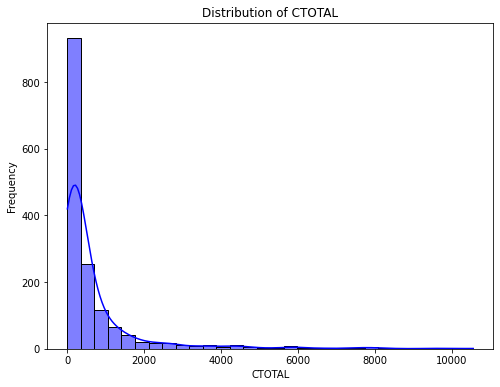

In [29]:
# Plot the distribution of the target variable CTOTAL
plt.figure(figsize=(8, 6))
sns.histplot(data['CTOTAL'], bins=30, kde=True, color='blue')
plt.title('Distribution of CTOTAL')
plt.xlabel('CTOTAL')
plt.ylabel('Frequency')
plt.show()


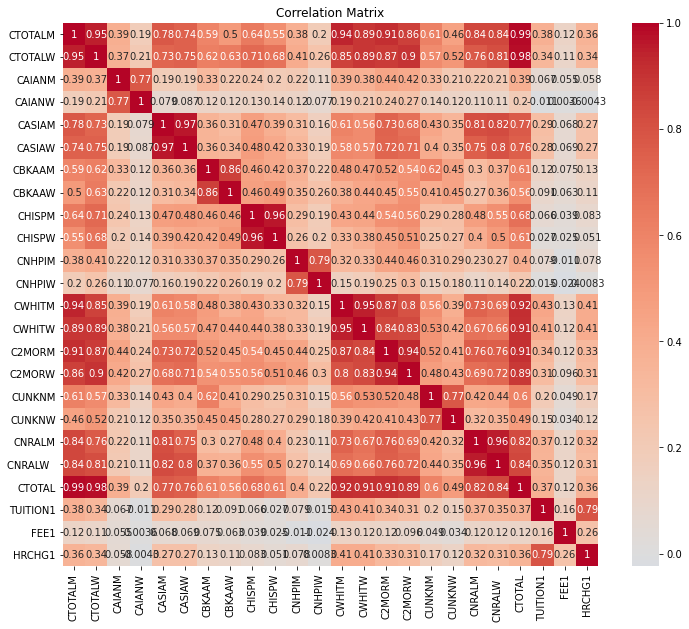

In [30]:
# visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

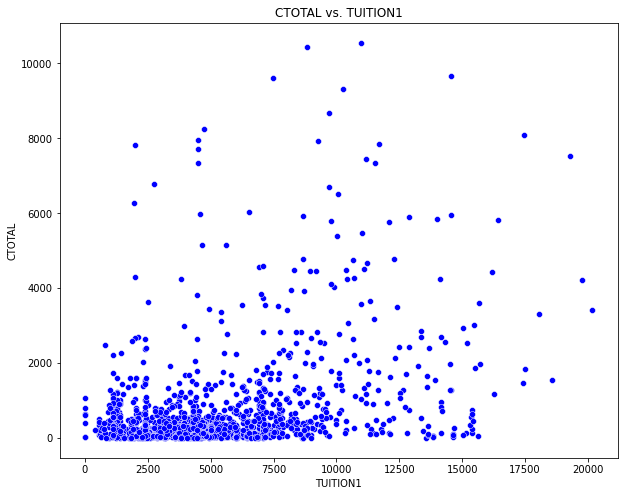

In [31]:
#visualize the scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TUITION1', y='CTOTAL', data=data, color='blue')
plt.title('CTOTAL vs. TUITION1')
plt.xlabel('TUITION1')
plt.ylabel('CTOTAL')
plt.show()

In [32]:
# target is CTOTAL
target  = data['CTOTAL']
# features are all the columns except CTOTAL
features  = data.drop('CTOTAL', axis=1)

In [33]:
# Preprocess numerical features
numeric_features = features.select_dtypes(include=['float64', 'int64'])
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Preprocess categorical features
categorical_features = features.select_dtypes(include=['category'])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])



In [34]:
# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features.columns),
        ('cat', categorical_transformer, categorical_features.columns)])

In [35]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [36]:
# Define and train the model using a pipeline
model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CTOTALM', 'CTOTALW', 'CAIANM', 'CAIANW', 'CASIAM', 'CASIAW', 'CBKAAM',
       'CBKAAW', 'CHISPM', 'CHISPW', 'CNHPIM', 'CNHPIW', 'CWHITM', 'CWHITW',
       'C2MORM', 'C2MORW', 'CUNKNM', 'CUNKNW', 'CNRALM', 'CNRALW  ',
       'TUITION1', 'FEE1', 'HRCHG1'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('regressor', LinearRegression())])

In [37]:
# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [38]:
#  Print the evaluation metrics
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 9.381975065084498e-25
R-squared: 1.0


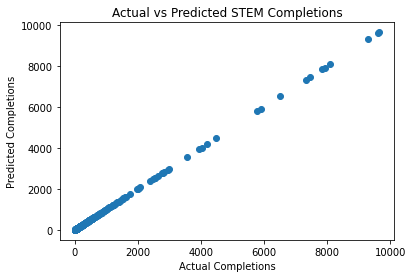

In [39]:
# Plot actual vs predicted completions
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Completions')
plt.ylabel('Predicted Completions')
plt.title('Actual vs Predicted STEM Completions')
plt.show()

In [40]:
# Extract and display coefficients
coefficients = model.named_steps['regressor'].coef_
feature_names = numeric_features

feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
print(feature_importance.sort_values(by='Coefficient', ascending=False))

                     Feature   Coefficient
12        (C, W, H, I, T, M)  2.898652e+02
0      (C, T, O, T, A, L, M)  2.113747e+02
13        (C, W, H, I, T, W)  1.832482e+02
1      (C, T, O, T, A, L, W)  1.417486e+02
8         (C, H, I, S, P, M)  1.016102e+02
9         (C, H, I, S, P, W)  9.602549e+01
18        (C, N, R, A, L, M)  7.312307e+01
4         (C, A, S, I, A, M)  6.170865e+01
5         (C, A, S, I, A, W)  5.019940e+01
7         (C, B, K, A, A, W)  4.825721e+01
6         (C, B, K, A, A, M)  4.530284e+01
19  (C, N, R, A, L, W,  ,  )  4.256827e+01
16        (C, U, N, K, N, M)  2.363528e+01
17        (C, U, N, K, N, W)  1.783737e+01
14        (C, 2, M, O, R, M)  1.771854e+01
15        (C, 2, M, O, R, W)  1.410155e+01
3         (C, A, I, A, N, W)  3.449197e+00
2         (C, A, I, A, N, M)  2.915260e+00
11        (C, N, H, P, I, W)  1.829190e+00
10        (C, N, H, P, I, M)  1.410340e+00
21              (F, E, E, 1)  2.511130e-13
22        (H, R, C, H, G, 1) -1.096874e-13
20  (T, U, 

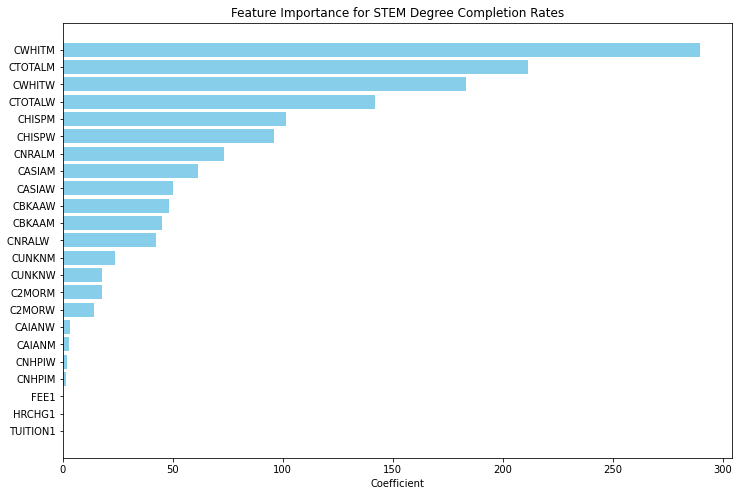

In [41]:
# Ensure that feature names are strings
feature_importance['Feature'] = feature_importance['Feature'].apply(lambda x: ''.join(x) if isinstance(x, tuple) else x)

# Sort feature importance by coefficient value
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.title('Feature Importance for STEM Degree Completion Rates')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient on top
plt.show()


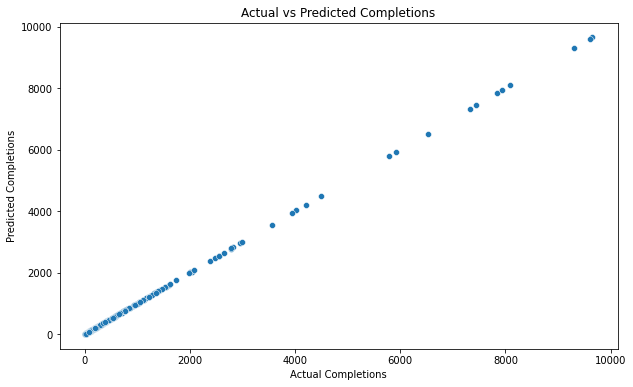

In [42]:
# Plot the results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Completions')
plt.ylabel('Predicted Completions')
plt.title('Actual vs Predicted Completions')
plt.show()


In [43]:
# Define and train the Ridge Regression model
ridge_model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', Ridge(alpha=1.0))])
ridge_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CTOTALM', 'CTOTALW', 'CAIANM', 'CAIANW', 'CASIAM', 'CASIAW', 'CBKAAM',
       'CBKAAW', 'CHISPM', 'CHISPW', 'CNHPIM', 'CNHPIW', 'CWHITM', 'CWHITW',
       'C2MORM', 'C2MORW', 'CUNKNM', 'CUNKNW', 'CNRALM', 'CNRALW  ',
       'TUITION1', 'FEE1', 'HRCHG1'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('regressor', Ridge())])

In [44]:
# Predict and evaluate
y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

In [45]:
# Print the evaluation metrics for Ridge Regression
print(f'Ridge Regression Mean Squared Error: {mse_ridge}')
print(f'Ridge Regression R-squared: {r2_ridge}')


Ridge Regression Mean Squared Error: 0.47315647081915463
Ridge Regression R-squared: 0.9999998036705474


In [46]:
# Define and train the Lasso Regression model
lasso_model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', Lasso(alpha=0.1))])
lasso_model.fit(X_train, y_train)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182858.61273363477, tolerance: 175977.1619502825
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CTOTALM', 'CTOTALW', 'CAIANM', 'CAIANW', 'CASIAM', 'CASIAW', 'CBKAAM',
       'CBKAAW', 'CHISPM', 'CHISPW', 'CNHPIM', 'CNHPIW', 'CWHITM', 'CWHITW',
       'C2MORM', 'C2MORW', 'CUNKNM', 'CUNKNW', 'CNRALM', 'CNRALW  ',
       'TUITION1', 'FEE1', 'HRCHG1'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('regressor', Lasso(alpha=0.1))])

In [47]:
# Predict and evaluate
y_pred_lasso = lasso_model.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
# Print the evaluation metrics for Lasso Regression
print(f'Lasso Regression Mean Squared Error: {mse_lasso}')
print(f'Lasso Regression R-squared: {r2_lasso}')

Lasso Regression Mean Squared Error: 2.751718035776581
Lasso Regression R-squared: 0.9999988582142927


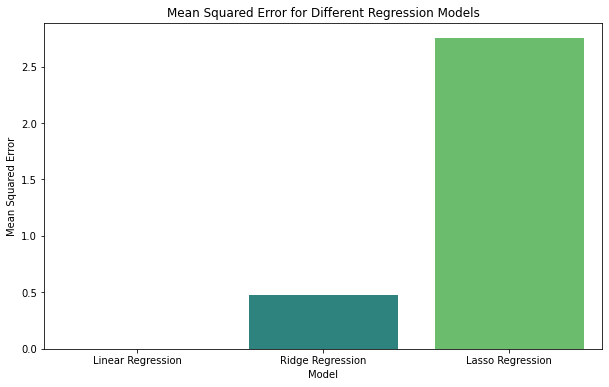

In [48]:
#result to table
result = pd.DataFrame({'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression'],
                       'Mean Squared Error': [mse, mse_ridge, mse_lasso],
                       'R-squared': [r2, r2_ridge, r2_lasso]})
# Plot the results in a bar chart and label the bars and r2 values
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Mean Squared Error', data=result, palette='viridis')
plt.title('Mean Squared Error for Different Regression Models')
plt.show()
